INSA Lyon - TDSI - Binôme 10

Ulysse RANÇON, Corentin VANNIER

# Testing the cardiGAN project

Our project is divided in two sections:
- The main part is the generation of artifical echocardiograms using Generative Adversarial Networks (GANs), and more specifically, NVIDIA's SPADE. Once we have a well-trained network, we can feed it anatomically-plausible masks thanks to Nathan Painchaud (Cardiac Segmentation with Strong Anatomical Guarantees, 2020) to generate as much echocardiograms as we want.
- The second part of our project is using those generated images to try and improve segmentation results by increasing the size of the training dataset. In this notebook, we will look at the distributions of both the original and the generated images, which could explain why we did not see any substantial improvement.

## A. Preparation

*Note: We recommend running this project on a Linux system. We haven't tested it on Windows or macOS.*

**1. To run this notebook, you will need two files: CAMUS, the original dataset, and CAMUSx, our dataset of generated images.**

```bash
camus05_256.hdf5
camusx_256.hdf5
```

**2. Also, make sure to have following Python packages installed:**

```python
# General purpose packages
h5py
numpy
tqdm
umap-learn
matplotlib
opencv-python

# SPADE packages
torch
torchvision
dominate
dill
scikit-image

# Tensorboard packages
tensorflow==1.15.0
scipy==1.2.0
pillow==6.1.0
```

**3. Using a terminal, clone the *NVIDIA SPADE* repository into the current folder:**

```bash
git clone https://github.com/corentinvannier/SPADE
cd SPADE
```

*Note: We are cloning our fork of SPADE because of this issue: https://github.com/NVlabs/SPADE/pull/131*


**4. Download the *Synchronized Batch Normalization* repository in `models/networks`:**

```bash
cd models/networks/
git clone https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
mv Synchronized-BatchNorm-PyTorch/sync_batchnorm .
rm -rf Synchronized-BatchNorm-PyTorch
cd ../../
```

**5. Add the CAMUS dataset (`camus05_256.hdf5`) to the `datasets` folder.**

**6. Run our script to extract the content of `camus05_256.hdf5` in the appropriate format for SPADE:**

```bash
cd datasets/
git clone https://github.com/urancon/cardiGAN
mv cardiGAN/prepare_dataset.py .
rm -rf cardiGAN
python3 prepare_dataset.py
cd ../
```

## B. Training and evaluating a SPADE model

**1. Train a new model from the terminal using the following command line:**

```bash
python3 train.py --name CAMUS --gpu_ids 0,1 --dataset_mode custom --no_instance --label_nc 3 --contain_dontcare_label \
        --preprocess_mode none --label_dir datasets/CAMUS/train/label --image_dir datasets/CAMUS/train/img \
        --load_size 256 --aspect_ratio 1 --crop_size 256 --ngf 48 --ndf 48 --batchSize 4 \
        --niter 20 --niter_decay 10 --tf_log --beta1 0 --beta2 0.999
```

*Note: Adapt the `--gpu_ids` parameter to your setup. Depending on your machine, this training can take quite some time.*

**2. Once this is done, evaluate the model on the test dataset:**

```bash
python3 test.py --name CAMUS --dataset_mode custom --no_instance --label_nc 3 --contain_dontcare_label \
        --preprocess_mode none --label_dir datasets/CAMUS/test/label --image_dir datasets/CAMUS/test/img \
        --load_size 256 --aspect_ratio 1 --crop_size 256 --ngf 48
```

**3. Observe the generated images by opening the results file in your web browser:**

```bash
firefox results/CAMUS/test_latest/index.html
```

*Note: Of course, adapt this line to your browser of choice.*

## C. Comparing the generated masks and images to CAMUS

To simplify things, we already generated images using Nathan Painchaud's masks and a SPADE network trained just like we showed you above.

**1. Please add these images (`camusx_256.hdf5`) to the `datasets` folder.**

**2. Next, we will import the necessary modules:**

In [1]:
import h5py
import umap
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

**3. Then, we will define a function to read the .hdf5 files:**

In [2]:
def get_hdf5(data_path, data_set='test', samples=200):
    i = 0
    with h5py.File(data_path, 'r') as f, tqdm(total=samples) as progress:
        for patient in f[data_set]:
            for view in f[data_set][patient]:
                for time in [0, 1]:
                    # Read the image and the mask
                    img = f[data_set][patient][view]['im'][time, :, :, :]
                    msk = f[data_set][patient][view]['gt'][time, :]
                    # Concatenate them
                    output_img = img.flatten() if i==0 else np.vstack((output_img, img.flatten()))
                    output_msk = msk.flatten() if i==0 else np.vstack((output_msk, msk.flatten()))
                    # Update
                    i += 1
                    progress.update(1)
                    if i >= samples:
                        return output_img, output_msk

**4. Using this function, we can load the two datasets:**

In [3]:
n = 1600
cam_file = "datasets/camus05_256.hdf5"
gen_file = "datasets/camusx_256.hdf5"

cam_img, cam_msk = get_hdf5(cam_file, 'train', n)
gen_img, gen_msk = get_hdf5(gen_file, 'train', n)

img = np.vstack((cam_img, gen_img))
msk = np.vstack((cam_msk, gen_msk))

100%|██████████| 1600/1600 [01:12<00:00, 21.95it/s]


**5. Now, let's train UMAP models on both the masks and images.**

In [4]:
msk_model = umap.UMAP(n_components=3)

msk_model.fit(msk)

cam_msk_points = msk_model.transform(cam_msk)
gen_msk_points = msk_model.transform(gen_msk)

In [5]:
img_model = umap.UMAP(n_components=3)

img_model.fit(img)

cam_img_points = img_model.transform(cam_img)
gen_img_points = img_model.transform(gen_img)

**6. Once the training is complete, we can plot the results:**

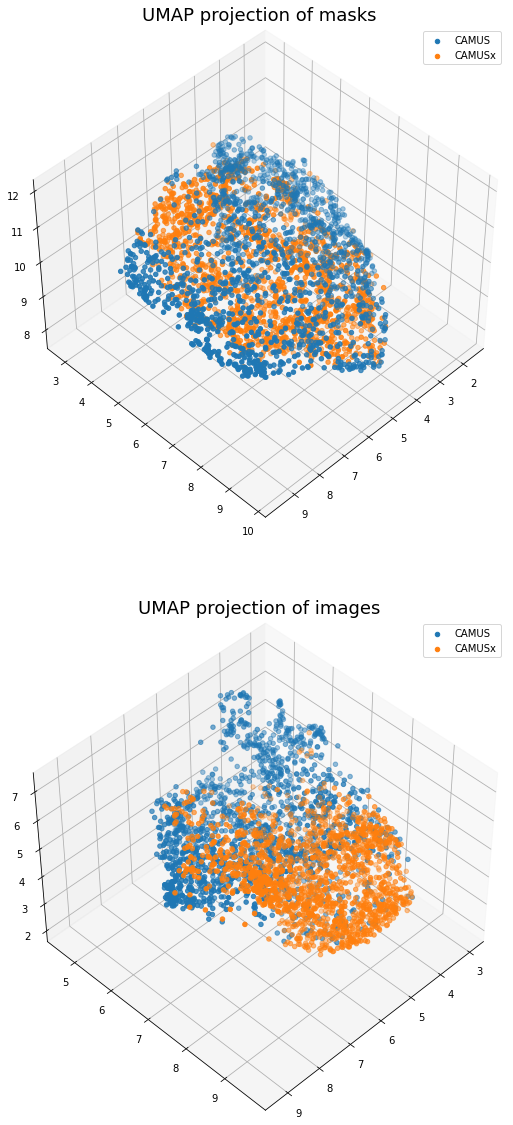

In [6]:
fig = plt.figure(figsize=[10,20])

ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter(cam_msk_points[:, 0], cam_msk_points[:, 1], cam_msk_points[:, 2])
ax1.scatter(gen_msk_points[:, 0], gen_msk_points[:, 1], gen_msk_points[:, 2])
ax1.view_init(elev=45, azim=45)

plt.title('UMAP projection of masks', fontsize=18)
plt.legend(['CAMUS', 'CAMUSx'])

ax2 = fig.add_subplot(212, projection='3d')
ax2.scatter(cam_img_points[:, 0], cam_img_points[:, 1], cam_img_points[:, 2])
ax2.scatter(gen_img_points[:, 0], gen_img_points[:, 1], gen_img_points[:, 2])
ax2.view_init(elev=45, azim=45)

plt.title('UMAP projection of images', fontsize=18)
plt.legend(['CAMUS', 'CAMUSx'])

plt.show()

*Note: You can change the orientation of the plot with the `azim` argument of `view_init`.*

As you should be able to see from the 3D plot, the distributions of the CAMUS and the generated dataset are quite distinct, especially for images, which could explain why adding generated echocardiograms to CAMUS doesn't improve segmentation results.

We suspect that the generated images contain some unnoticeable patterns that separates them from the original dataset.